In [1]:
from glob import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

from skimage import io
from skimage.color import label2rgb, rgb2gray
from skimage import morphology
from skimage.morphology import closing, square
from skimage.filters import threshold_yen
from skimage.segmentation import clear_border, watershed
from skimage.measure import label, regionprops
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

plt.rcParams['figure.figsize'] = [10, 5]

In [2]:
DATASET_ROOT = "/Users/a1/Desktop/pollen_dataset_2024_11_22/samples"
OBJECTS_ROOT_1 = "/Users/a1/Desktop/pollen_dataset_2024_11_22/objects_clean"

In [3]:
all_images = []
target_classes = os.listdir(DATASET_ROOT)
for class_name in target_classes:
    all_images.extend(glob(os.path.join(DATASET_ROOT, class_name, "*.jpg"), recursive=True))
print(f"Total amount of images: {len(all_images)}")

Total amount of images: 1358


# Visualisation 

In [4]:
def draw_detections(image, label_image):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
    
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    ax1.imshow(image)
    ax2.imshow(image_label_overlay)
    ax1.set_axis_off()
    ax2.set_axis_off()
    plt.tight_layout()
    plt.show()

# Detect objects

In [ ]:
def object_detection_stage(image_rgb, radius=25):
    image_rgb = np.copy(image_rgb)
    image = rgb2gray(image_rgb)
    # apply threshold
    thresh = threshold_yen(image)
    bw = closing(image < thresh, square(25))
    bw =  morphology.remove_small_holes(
        morphology.remove_small_objects(bw, 5000), 5000
    )
    bw = morphology.isotropic_erosion(bw, radius)
    bw = morphology.isotropic_dilation(bw, radius)
    label_image = label(bw)
    return label_image

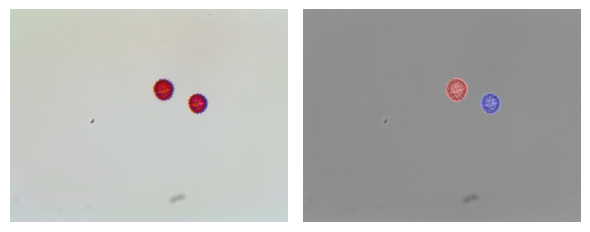

In [6]:
image_rgb = io.imread(all_images[70])
label_image = object_detection_stage(image_rgb)
draw_detections(image_rgb, label_image)

# Extract detected objects

# Separate Objects

In [7]:
def extract_objects(image_rgb, labels_image, min_distance, padding):
    labels = ndi.binary_fill_holes(labels_image)
    labels = morphology.binary_erosion(labels)
    labels = morphology.binary_dilation(labels).astype(np.uint8)
    
    # Now we want to separate the two objects in image
    # Generate the markers as local maxima of the distance to the background
    distance = ndi.distance_transform_edt(labels)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=labels, min_distance=min_distance)
    if len(coords) > 0:
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)
        labels = watershed(-distance, markers, mask=labels)


    masked_rgb_images = []
    for region in regionprops(labels):
        minr, minc, maxr, maxc = region.bbox    
        minr, minc, maxr, maxc = max(0, minr-padding), max(0, minc-padding), min(image_rgb.shape[0]-1, maxr+padding), min(image_rgb.shape[1]-1, maxc+padding)
        label_patch = np.copy(labels[minr:maxr, minc:maxc])
        label_patch = clear_border(label_patch)
        image_rgb_patch = np.copy(image_rgb[minr:maxr, minc:maxc])
        image_rgb_patch = np.where((label_patch > 0)[...,None], image_rgb_patch, 0).astype(np.uint8)
        masked_rgb_images.append(image_rgb_patch)
    return masked_rgb_images
    

def object_separation_stage(image_rgb, labels, area_threshold = 20, padding=10, min_distance=40):
    image_rgb = np.copy(image_rgb)
    masked_rgb_images = []
    for region in regionprops(labels):
        if region.area < area_threshold:
            continue  # Skipping small objects
        minr, minc, maxr, maxc = region.bbox            
        minr, minc, maxr, maxc = max(0, minr-padding), max(0, minc-padding), min(image_rgb.shape[0]-1, maxr+padding), min(image_rgb.shape[1]-1, maxc+padding)
        
        label_patch = np.copy(labels[minr:maxr, minc:maxc])
        label_patch = clear_border(label_patch)
        image_rgb_patch = np.copy(image_rgb[minr:maxr, minc:maxc])
        image_rgb_patch = np.where((label_patch > 0)[...,None], image_rgb_patch, 0).astype(np.uint8)
        masked_rgb_images.extend(extract_objects(image_rgb_patch, label_patch, min_distance, padding))
    return masked_rgb_images

In [ ]:
for imx, path in enumerate(tqdm(all_images)):
    rel_path = os.path.relpath(path, start=DATASET_ROOT)
    patch_template = os.path.splitext(rel_path)[0] + "_{}.png"
    patch_template = os.path.join(OBJECTS_ROOT_1, patch_template)
    os.makedirs(os.path.dirname(patch_template), exist_ok=True)   
    try:
        image_rgb = io.imread(path)
        label_image = object_detection_stage(image_rgb)
        masked_rgb_images = object_separation_stage(image_rgb, label_image)
        for i, patch in enumerate(masked_rgb_images):
            io.imsave(patch_template.format(i), patch)
    except:
        print(f"Cannot process image {path}")

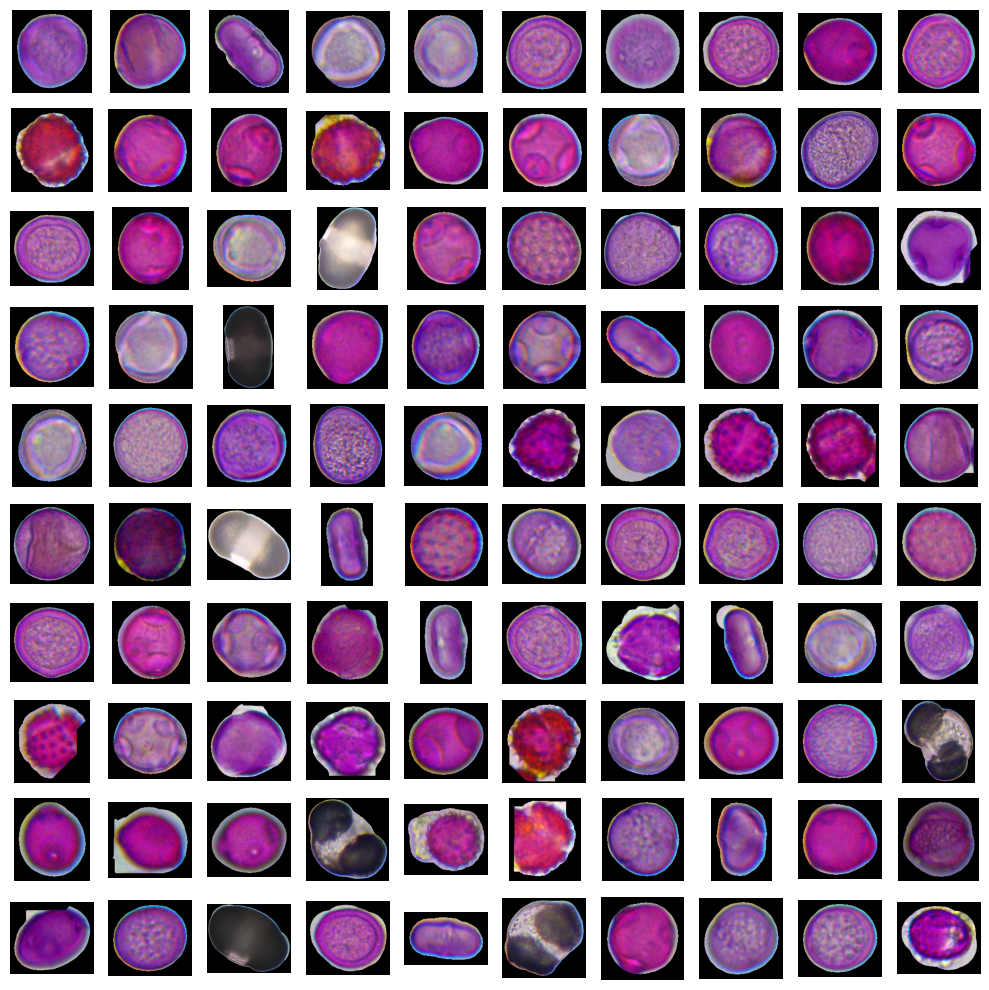

In [9]:
all_obj_images = glob(os.path.join(OBJECTS_ROOT_1,  "**", "*.png"), recursive=True)
all_obj_images = random.sample(all_obj_images, 100)
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for ax, img_path in zip(axs.flatten(), all_obj_images):
    image_rgb = io.imread(img_path)
    ax.imshow(image_rgb)
    ax.set_axis_off()
plt.tight_layout()
plt.savefig("obj_sample.png")
plt.show()